In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

import src
from src.reload import deep_reload

Please run make_data_structure.sh prior to this

In [2]:
'''
Making the destinations graph
'''

gdf_place = gpd.read_file('Data/Places/tl_2023_06_place.shp')

df_place = pd.read_excel(
    'Data/Places/SUB-IP-EST2022-POP-06.xlsx',
    skiprows = 3, skipfooter = 5,
)

df_place = df_place.rename(columns = {'Unnamed: 0': 'Name', 'Unnamed: 1': 'Base'})

df_place_names = df_place['Name'].to_numpy()
df_place_population = df_place[2022].to_numpy()
gdf_place_names = gdf_place['NAME'].to_numpy()

In [3]:
pop = {}

for name in gdf_place_names:

    for idx, check_name in enumerate(df_place_names):

        if name in check_name:

            pop[name] = df_place_population[idx]
            break

populations = []

for name in gdf_place_names:

    populations.append(pop.get(name, 0))

gdf_place['population'] = populations
gdf_place['log_population'] = np.log(gdf_place['population'])

In [6]:
gdf_place_sel = gdf_place[gdf_place['population'] > 1e3]
lon, lat = np.array([x.coords.xy for x in gdf_place_sel.geometry.centroid]).T[0]
names = gdf_place_sel['NAME'].to_numpy()
pop = gdf_place_sel['population'].to_numpy()

nodes = []

for idx in range(len(names)):

    node = {
        'id': names[idx],
        'x': lon[idx],
        'y': lat[idx],
        'population': pop[idx],
        'type': 'place',
    }

    nodes.append(node)

links = []
    
graaces = src.graph.graph_from_nlg({'nodes': nodes, 'links': links})

In [7]:
graph_places.number_of_nodes(), graph_places.number_of_edges()

(479, 0)

In [8]:
src.graph.graph_to_json(graph_places, 'Outputs/places.json')

In [9]:
with open('Data/AFDC/evse_stations.json', 'r') as file:
    evse = json.load(file)

In [10]:
stations_raw = []

for station in evse['fuel_stations']:

    checks = (
        station['state'] == 'CA',
        station['ev_dc_fast_num'] is not None,
        station['access_code'] == 'public',
        station['status_code'] == 'E',
    )

    if all(checks):

        stations_raw.append(station)

In [11]:
'''
Merging equipment labeled as individual stations but actually forming a single station
'''

longitude = np.array([station['longitude'] for station in stations_raw])
latitude = np.array([station['longitude'] for station in stations_raw])
ids = np.array([station['id'] for station in stations_raw])
networks = np.array([station['ev_network'] for station in stations_raw])

x_s, x_f = np.meshgrid(longitude, longitude, indexing  = 'ij')
y_s, y_f = np.meshgrid(latitude, latitude, indexing  = 'ij')

distance = src.utilities.haversine(x_s, y_s, x_f, y_f)

In [12]:
def none_then_zero(x):

    if x is None:

        return 0

    else:

        return x

stations_merged = [station.copy() for station in stations_raw]

drop = []

threshold = 100

for idx, row in enumerate(distance):

    if ids[idx] in drop:

        continue

    for col, dist in enumerate(row):

        if (dist <= threshold) & (idx != col) & (networks[idx] == networks[col]):

            drop.append(ids[col])

            stations_merged[idx]['ev_dc_fast_num'] = (
                none_then_zero(stations_raw[idx]['ev_dc_fast_num']) +
                none_then_zero(stations_raw[col]['ev_dc_fast_num'])
            )

            stations_merged[idx]['ev_level2_evse_num'] = (
                none_then_zero(stations_raw[idx]['ev_level2_evse_num']) +
                none_then_zero(stations_raw[col]['ev_level2_evse_num'])
            )

In [13]:
stations_merged = [station for station in stations_merged if station['id'] not in drop]

In [14]:
len(stations_merged), len(stations_raw)

(1689, 2149)

In [15]:
df_stations = pd.DataFrame.from_dict(stations_merged)

In [16]:
node_attributes = {
    'x': 'lambda n: n["longitude"]',
    'y': 'lambda n: n["latitude"]',
    'n_dcfc': 'lambda n: n["ev_dc_fast_num"]',
    'n_acl2': 'lambda n: n["ev_level2_evse_num"]',
    'network': 'lambda n: n["ev_network"]',
    'name': 'lambda n: n["station_name"]',
    'address': 'lambda n: n["street_address"]',
    'city': 'lambda n: n["city"]',
    'state': 'lambda n: n["state"]',
    'zip': 'lambda n: n["zip"]',
    'access_code': 'lambda n: n["access_code"]',
    'status_code': 'lambda n: n["status_code"]',
    'type': 'lambda n: "station"',
}

nlg = src.graph.nlg_from_dataframe(df_stations, node_attributes)

graph_station = src.graph.graph_from_nlg(nlg)

mapping = {n: f'station_{n}' for n in graph_station.nodes}

graph_station = nx.relabel_nodes(graph_station, mapping)

In [17]:
graph_empty = nx.union(graph_places, graph_station)

In [18]:
graph_empty.number_of_nodes(), graph_empty.number_of_edges()

(2168, 0)

In [19]:
src.graph.graph_to_json(graph_empty, 'Outputs/graph_empty.json')

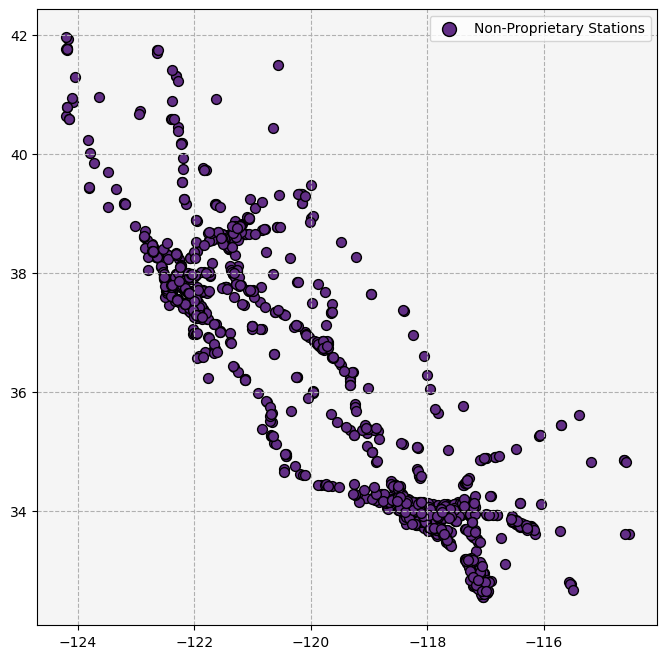

In [123]:
fig, ax = plt.subplots(figsize = (8, 8))

# outline[outline['STATEFP'] == '06'].plot(ax = ax, fc = 'none', ec = 'k')

kw = {
    'show_links': False,
    'scatter': {
        's': .5,
        'ec': 'none',
        'fc': 'k',
        'zorder': 0,
    },
}

# src.figures.plot_graph(atlas, ax = ax, **kw)

kw = {
    'show_links': False,
    'scatter': {
        's': 300,
        'ec': 'k',
        'fc': '#ffd601',
        'zorder': 4,
        'label': 'Selected Locations',
    },
}

# src.figures.plot_graph(cities, ax = ax, **kw)

# x = [n['x'] for n in cities._node.values()]
# y = [n['y'] for n in cities._node.values()]
# n = [f'{n}' for n in range(cities.number_of_nodes())]

kw = {
    'zorder': 5,
    'horizontalalignment': 'center',
    'verticalalignment': 'center',
    'fontstyle': 'italic',
    'fontsize': 'large',
    'fontfamily': 'monospace',
}

# for idx in range(len(n)):
    
#     ax.text(x[idx], y[idx], n[idx], **kw)

kw = {
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': 'dashed',
}

ax.grid(**kw)

kw = {
    'show_links': False,
    'scatter': {
        's': 50,
        'ec': 'k',
        'fc': '#622e86',
        'zorder': 1,
        'label': 'Non-Proprietary Stations',
    },
}

src.figures.plot_graph(graph, ax = ax, **kw)

kw = {
    'fontsize': 'medium',
}
    

legend = ax.legend(**kw)

for h in legend.legendHandles:
    h._sizes = [100]
    

# fig.savefig('Paper/figs/California_SNG_NP.png', bbox_inches = 'tight', dpi = 300)

In [136]:
graph = graph_empty

In [137]:
un, unc = np.unique(
    [n.get('network', 'none') for n in graph._node.values()],
    return_counts = True,
)

In [138]:
un, unc

(array(['7CHARGE', 'ABM', 'AMPUP', 'BP_PULSE', 'Blink Network',
        'CHARGELAB', 'CHARGENET', 'CIRCLE_K', 'ChargePoint Network',
        'EV Connect', 'EVCS', 'EVGATEWAY', 'EVRANGE', 'Electrify America',
        'FLO', 'LOOP', 'NOODOE', 'Non-Networked', 'POWERFLEX',
        'RIVIAN_ADVENTURE', 'SHELL_RECHARGE', 'SWTCH', 'Tesla', 'Volta',
        'eVgo Network', 'none'], dtype='<U19'),
 array([  9,   1,   1,  15,  13,   2,   3,   7, 266,  48,  73,  23,   8,
        244,   1,   6,   4, 124,  12,  16,  35,   1, 419,  18, 340,  15]))

In [139]:
indices = np.flip(np.argsort(unc))
unc = unc[indices]
un = un[indices]

In [147]:
combinations = [[n] for idx, n in enumerate(un) if unc[idx] >= 20]
combinations.append([n for idx, n in enumerate(un) if unc[idx] < 20])

In [148]:
labels = [c[0] for c in combinations]
labels[-1] = 'Other Networks'

In [149]:
subgraphs = {}

for idx, label in enumerate(labels):

    comb = combinations[idx]

    nodes = [k for k, v in graph._node.items() if v.get('network', '') in comb]

    subgraphs[label] = src.graph.subgraph(graph, nodes)

In [150]:
combinations

[['Tesla'],
 ['eVgo Network'],
 ['ChargePoint Network'],
 ['Electrify America'],
 ['Non-Networked'],
 ['EVCS'],
 ['EV Connect'],
 ['SHELL_RECHARGE'],
 ['EVGATEWAY'],
 ['Volta',
  'RIVIAN_ADVENTURE',
  'none',
  'BP_PULSE',
  'Blink Network',
  'POWERFLEX',
  '7CHARGE',
  'EVRANGE',
  'CIRCLE_K',
  'LOOP',
  'NOODOE',
  'CHARGENET',
  'CHARGELAB',
  'FLO',
  'SWTCH',
  'AMPUP',
  'ABM']]

In [151]:
x = []
n = []
h = []

for idx, combination in enumerate(combinations):

    x_i, n_i, h_i = src.analysis.redundancy_in_station(subgraphs[labels[idx]])
    
    x.append(x_i)
    n.append(n_i)
    h.append(h_i)

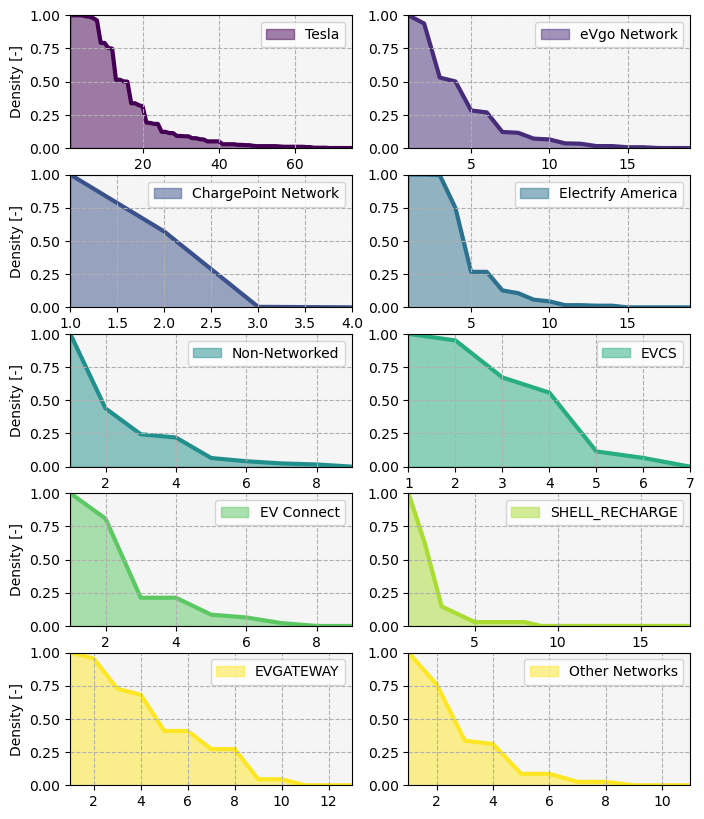

In [152]:
m = 8
rows = 5
columns = 2

cmap = src.figures.colormap('viridis')

fig, ax = plt.subplots(rows, columns, figsize = (4 * columns, 2 * rows))

idx = 0
for r in range(rows):
    for c in range(columns):

        color = cmap(idx / m * .999)

        kw = {
            'color': color,
            'zorder': 1,
            'lw': 3,
        }
        
        ax[r, c].plot(x[idx], h[idx].sf(x[idx]), **kw)
        
        kw = {
            'color': color,
            'zorder': 0,
            'alpha': .5,
            'label': labels[idx]
        }
        
        ax[r, c].fill_between(x[idx], 0, h[idx].sf(x[idx]), **kw)

        xlabel = None
        ylabel = None
        
        if r == 3:
            xlabel = 'Network In-Station Redundancy [ports]'

        if c == 0:
            ylabel = 'Density [-]'
        
        kw = {
            'xlim': [x[idx][0], x[idx][-1]],
            'ylim': [0, 1],
            'xlabel': xlabel,
            'ylabel': ylabel,
            'facecolor': 'whitesmoke',
        }
        
        ax[r, c].set(**kw)
        
        kw = {
            'ls': '--',
        }
        
        ax[r, c].grid(**kw)
        
        ax[r, c].legend()

        idx += 1

fig.savefig('Paper/figs/California_RIS_SF_All.png', bbox_inches = 'tight', dpi = 300)

In [79]:
x = []
n = []
h = []

for idx, combination in enumerate(combinations):

    x_i, n_i, h_i = src.analysis.redundancy_between_stations(
        subgraphs[labels[idx]], field = 'time', cutoff = 300,
    )
    
    x.append(x_i)
    n.append(n_i)
    h.append(h_i)

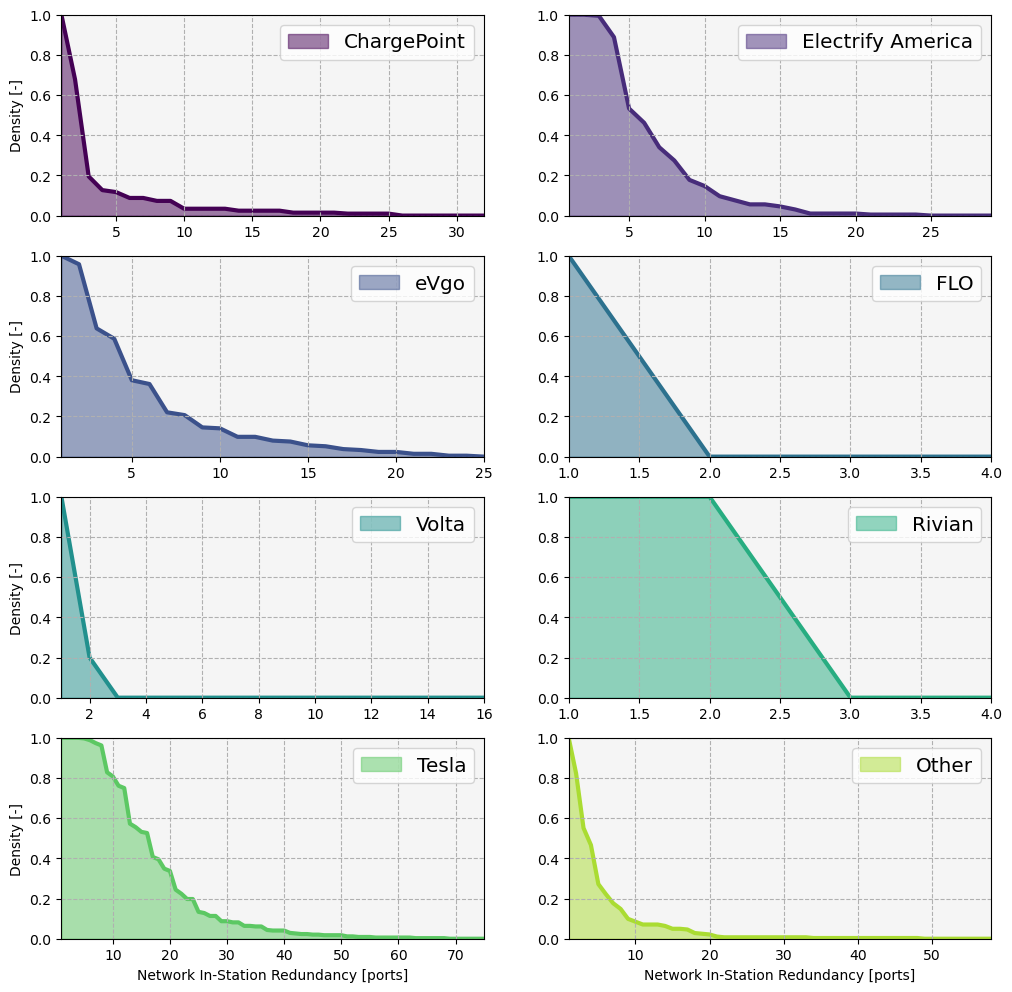

In [80]:
# m = len(combinations)

m = 8
rows = 4
columns = 2

cmap = src.figures.colormap('viridis')

fig, ax = plt.subplots(rows, columns, figsize = (6 * columns, 3 * rows))

idx = 0
for r in range(rows):
    for c in range(columns):

        color = cmap(idx / m * .999)

        kw = {
            'color': color,
            'zorder': 1,
            'lw': 3,
        }
        
        ax[r, c].plot(x[idx], h[idx].sf(x[idx]), **kw)
        
        kw = {
            'color': color,
            'zorder': 0,
            'alpha': .5,
            'label': labels[idx]
        }
        
        ax[r, c].fill_between(x[idx], 0, h[idx].sf(x[idx]), **kw)

        xlabel = None
        ylabel = None
        
        if r == 3:
            xlabel = 'Network In-Station Redundancy [ports]'

        if c == 0:
            ylabel = 'Density [-]'
        
        kw = {
            'xlim': [x[idx][0], x[idx][-1]],
            'ylim': [0, 1],
            'xlabel': xlabel,
            'ylabel': ylabel,
            'facecolor': 'whitesmoke',
        }
        
        ax[r, c].set(**kw)
        
        kw = {
            'ls': '--',
        }
        
        ax[r, c].grid(**kw)
        
        ax[r, c].legend(fontsize = 'x-large')

        idx += 1

fig.savefig('Paper/figs/California_RBS_300_SF_All.png', bbox_inches = 'tight', dpi = 300)

In [87]:
x = []
n = []
h = []

for idx, combination in enumerate(combinations):

    x_i, n_i, h_i = src.analysis.redundancy_between_stations(
        subgraphs[labels[idx]], field = 'time', cutoff = np.inf,
    )
    
    x.append(x_i)
    n.append(n_i)
    h.append(h_i)

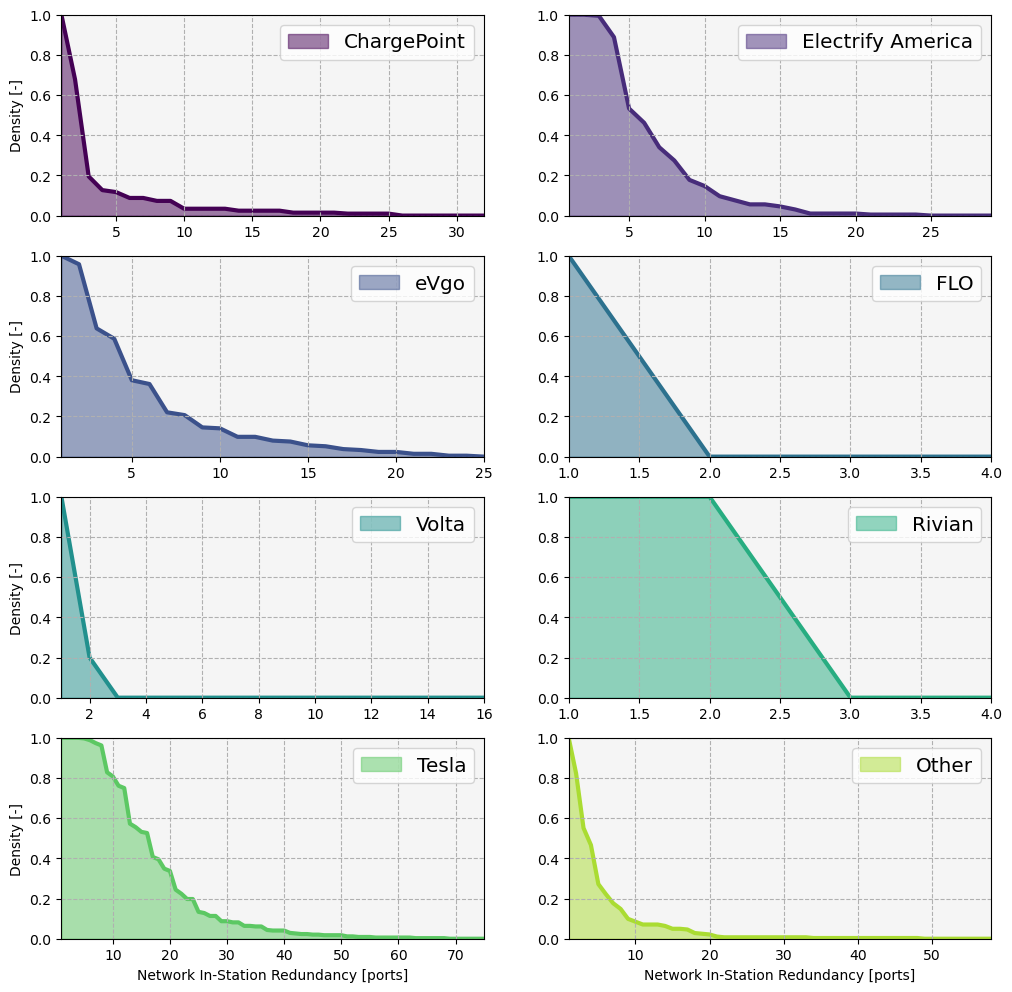

In [88]:
# m = len(combinations)

m = 8
rows = 4
columns = 2

cmap = src.figures.colormap('viridis')

fig, ax = plt.subplots(rows, columns, figsize = (6 * columns, 3 * rows))

idx = 0
for r in range(rows):
    for c in range(columns):

        color = cmap(idx / m * .999)

        kw = {
            'color': color,
            'zorder': 1,
            'lw': 3,
        }
        
        ax[r, c].plot(x[idx], h[idx].sf(x[idx]), **kw)
        
        kw = {
            'color': color,
            'zorder': 0,
            'alpha': .5,
            'label': labels[idx]
        }
        
        ax[r, c].fill_between(x[idx], 0, h[idx].sf(x[idx]), **kw)

        xlabel = None
        ylabel = None
        
        if r == 3:
            xlabel = 'Network In-Station Redundancy [ports]'

        if c == 0:
            ylabel = 'Density [-]'
        
        kw = {
            'xlim': [x[idx][0], x[idx][-1]],
            'ylim': [0, 1],
            'xlabel': xlabel,
            'ylabel': ylabel,
            'facecolor': 'whitesmoke',
        }
        
        ax[r, c].set(**kw)
        
        kw = {
            'ls': '--',
        }
        
        ax[r, c].grid(**kw)
        
        ax[r, c].legend(fontsize = 'x-large')

        idx += 1

# fig.savefig('Paper/figs/California_RBS_600_SF_All.png', bbox_inches = 'tight', dpi = 300)